## Определение стоимости автомобилей

### Описание проекта
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

В рамках данного проекта построим модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Инструкция по выполнению проекта

В рамках данного проекта не будем ограничивайтесь градиентным бустингом. Также попробуем и более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируем и сравним характеристики моделей: скорость работы, точность результата.

Основные шаги:
* Загрузка и подготовка данных.
* Обучение разных моделей. Для каждой попробуем различные гиперпараметры.
* Проанализируем скорость работы и качество моделей.
* Для оценки качества моделей применяется метрика RMSE.
* Целевое значние метрики RMSE -  меньше 2500.


### Описание данных

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:
* Price — цена (евро)

## Импорты

In [1]:
import numpy as np
import pandas as pd
# import pandas_profiling
import math 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, SCORERS
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor, cv, Pool
from lightgbm import LGBMRegressor

import optuna

import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_columns = 300
pd.options.display.max_rows = 400

## Подготовка данных

### Обработка пропусков, дубликатов и аномалий 

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv') #путь для ревьюера
except FileNotFoundError:
    df = pd.read_csv('datasets/autos.csv')

In [3]:
display(df.head())
df.info()
df.describe()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


По результатам предварительного анализа и отчета pandas_profiling можно сделать следующие наблюдения:
* даты стоит преобразовать из object в DateTime
* Нули в Price, Power, RegistrationMonth; 
* Пропуски в VehicleType (10%), Gearbox, Model, FuelType, NotRepaired (20%);
* Выбросы в RegistrationYear. Например 9999, 1000. Думаю там не может быть больше 2016;
* в NumberOfPictures почему то одни нули, можно удалить этот признак;
* есть 4 строки дубликата, удалим их;

Нули в Price точно придется удалить, так как это целевой признак





In [4]:
# приведем признаки с датой к стандартному отображению времени
for date in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
type(df['DateCrawled'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
# удалим дубликаты и признак c фотографиями
df = df.drop_duplicates().drop('NumberOfPictures', axis=1)


In [6]:
# %%time
# profile = df.profile_report() 
# profile.to_file("report.html")

In [7]:
# удалим нули в Price
df = df[df['Price'] != 0]

In [8]:
# для пропусков в категориальных признаках, зададим категорию 'unknown'
df[['NotRepaired', 'FuelType', 'Model', 'Gearbox', 'VehicleType']] = df[
    ['NotRepaired', 'FuelType', 'Model', 'Gearbox', 'VehicleType']].fillna('unknown')


In [9]:
# с пропусками вроде разобрались
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343593 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343593 non-null  datetime64[ns]
 1   Price              343593 non-null  int64         
 2   VehicleType        343593 non-null  object        
 3   RegistrationYear   343593 non-null  int64         
 4   Gearbox            343593 non-null  object        
 5   Power              343593 non-null  int64         
 6   Model              343593 non-null  object        
 7   Kilometer          343593 non-null  int64         
 8   RegistrationMonth  343593 non-null  int64         
 9   FuelType           343593 non-null  object        
 10  Brand              343593 non-null  object        
 11  NotRepaired        343593 non-null  object        
 12  DateCreated        343593 non-null  datetime64[ns]
 13  PostalCode         343593 non-null  int64   

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

<AxesSubplot:ylabel='Frequency'>

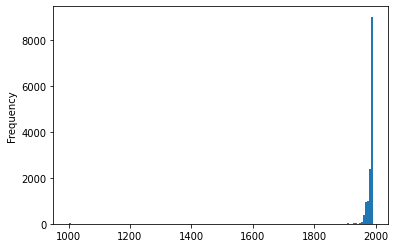

In [10]:
# посмотрим на выбросы в дате регистрации
df[df['RegistrationYear'] < 1992]['RegistrationYear'].plot(kind='hist', bins=150)


<AxesSubplot:ylabel='Frequency'>

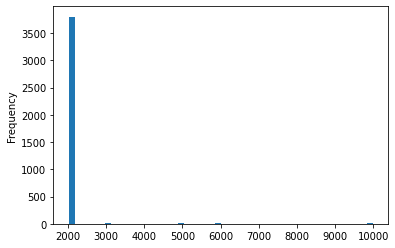

In [11]:
df[df['RegistrationYear'] > 2017]['RegistrationYear'].plot(kind='hist', bins=50)

Судя по данным - у нас на руках историческая выборка за 2016 год  
Соответственно логично удалить данные с годом регистрации автомобиля > 2016  
Что касается старых машин, 5 персентиль - 1992 год, также встречаются аномальные значения 1000. Думаю можно убрать все что старше 1950. В принципе предсказание стоимости старых машин дело очень индивидуальное.

In [12]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1950)]

Осталось разобраться с нулями в Power и RegistrationMonth.
С лошадиными силами можно попробовать придумать функцию которая заменит ноль, при условии нахождения аналогичной модели и года в выборке.  
Но прока просто удалю нули

Считаю, что для целей обучения RegistrationMonth можно в принципе не использовать (достаточно RegistrationYear).
Также думаю, что DateCrawled, LastSeen и DateCreated о цене автомобиля нам мало что скажут. Возможно стоит удать и PostalCode, чтобы не путать модель, но пока оставлю.

In [13]:
df_test = df.copy()

<AxesSubplot:xlabel='Power', ylabel='Count'>

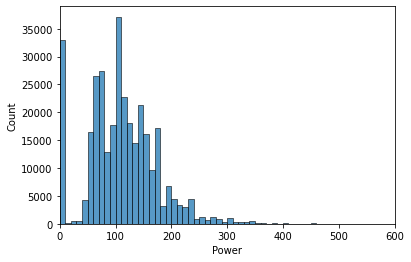

In [14]:
plt.xlim(0, 600)
sns.histplot(df['Power'], binwidth=10)


Сделалаем замену аномалий для Power через groupby и transform. Оставшиеся аномалии удалил.

Вроде неплохо получилось, сохранил порядка 30 000 наблюдений.

In [15]:
# посчитаем медиану мощности для df, сгрупированного по марке, модели и году
# transform для groupby преобразует объект groupby в датафрейм с исходным индексом
power_transformed = df.groupby(['Brand', 'Model', 'RegistrationYear'], as_index=False)['Power'].transform('median')
                                                                                      

In [16]:
# преобразуем исходный датафрейм по условию
df.loc[((df['Brand'] != 'unknown') | (df['Model'] != 'unknown')) &\
   ((df['Power'] < 30) | (df['Power'] > 600)), 'Power'] = power_transformed

In [17]:
# кол-во нулей прилично сократилось
df[df['Power'] == 0]['Power'].count()

2025

In [18]:
# удалим оставшиеся аномалии по Power
df = df.loc[(df['Power'] > 30) & (df['Power'] < 600)]

In [19]:
# удалим неинформативные столбцы
df = df.drop(['DateCrawled', 'RegistrationMonth', 'LastSeen', 'DateCreated'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,unknown,1993,manual,75.0,golf,150000,petrol,volkswagen,unknown,70435
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,90480
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,60437


Преобразуем Postal Code в явный категориальный признак.  
Оставим только первую цифру, указывающую на группу штатов (всего их 9).  
Две цифры ничего кажется не указывают, а 3 - это уже 700 вариантов


In [20]:

df['PostalCode'] = df['PostalCode'].astype('str').transform(lambda x: x[:1])
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,unknown,1993,manual,75.0,golf,150000,petrol,volkswagen,unknown,7
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes,6
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,9
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,9
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,6


### Кодирование  данных
Для базовых моделей придется закодировать данные.  
Для CatBoost это делать не обязательно, да и качество на незакодированных данных может получится больше (у CatBoost более сложные, чем OHE алгоритмы кодирования)

In [21]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']
# encoder = OneHotEncoder(drop='first').fit(df[categorical])
# display(encoder.transform(df[categorical]))

In [22]:
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)

# параметр drop_first=True позволяет избавиться от фиктивных признаков

## Обучение моделей

 Обучим различные модели.  
 Проверим их кросс-валидацией
 
 Предсказания на тестовой выборке посмотрим в самом конце.

### Разбиение на выборки

In [23]:
features = df_encoded.drop('Price', axis = 1)
target = df_encoded['Price']
RANDOM_STATE=12345

Пока разобью на три выборки с валидационной. Потом посмотрим нужна ли она мне, возможно стоит воспользоваться кроссвалидацией и оставить только обучающую и тестовую

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE) 

print(
    'Размер обучающей выборки:', features_train.shape[0],
    '\nРазмер тестовой выборки', features_test.shape[0])

Размер обучающей выборки: 261445 
Размер тестовой выборки 65362


### Масштабирование данных

In [25]:
# обучим StandardScaler() на обучающей выборке
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler().fit(features_train[numeric])

# масштабируем выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head(5))
features_test.head(5)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,...,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes,PostalCode_2,PostalCode_3,PostalCode_4,PostalCode_5,PostalCode_6,PostalCode_7,PostalCode_8,PostalCode_9
138306,-0.723689,-1.108621,0.578476,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,...,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes,PostalCode_2,PostalCode_3,PostalCode_4,PostalCode_5,PostalCode_6,PostalCode_7,PostalCode_8,PostalCode_9
273602,0.042570,1.004686,0.578476,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Построение моделей. Линейная регрессия

In [26]:
# создадим функцию для вывода основных метрик качества моделей регрессии
def model_metrics(target, predictions):
    print(f'RMSE: {np.sqrt(mean_squared_error(target, predictions)):.2f}')
    print(f'MSE:  {mean_squared_error(target, predictions):.2f}')
    print(f'R2:   {r2_score(target, predictions):.4f}')
    print(f'MAE:  {mean_absolute_error(target, predictions):.2f}')
    print(f'MAPE: {mean_absolute_percentage_error(target, predictions):.2f}')
    print('_'*20)

In [27]:
# построим константную модель
model_dummy = DummyRegressor().fit(features_train, target_train)
predictions_dummy = model_dummy.predict(features_train) 
model_metrics(target_train, predictions_dummy)

RMSE: 4544.10
MSE:  20648820.06
R2:   0.0000
MAE:  3566.07
MAPE: 16.98
____________________


In [28]:
cross_val_score(model_dummy, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()

-4544.091132870171

In [29]:
%%time
model_lr = LinearRegression().fit(features_train, target_train)

Wall time: 8.26 s


In [30]:
# проверим метрику RMSE с помощью кроссвалидации
cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=5).mean()

-2605.2422120571878

Значение метрики похоже на правду, но почему оно отрицательное?

В машинном обучении метрику можно измерять в двух концепциях: через потери (чем меньше, тем лучше) или функции полезности (чем больше, тем лучше), переход от одних к другим осуществляется через домножение на -1. Вот в cross_val_score и ряде других алгоритмов sklearn в качестве метрики служит функция полезности (а так как rmse является функцией потерь она домножается на -1)

### Случайный лес

In [31]:
# %%time
# model_rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(features_train, target_train)


In [32]:
%%time
model_rf = RandomForestRegressor(n_estimators=50, max_depth=3 ,random_state=RANDOM_STATE).fit(features_train, target_train)


Wall time: 1min 6s


In [33]:
%%time
# проверим метрику RMSE с помощью кроссвалидации
cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=3).mean()

Wall time: 2min 7s


-2910.230962616504

<AxesSubplot:>

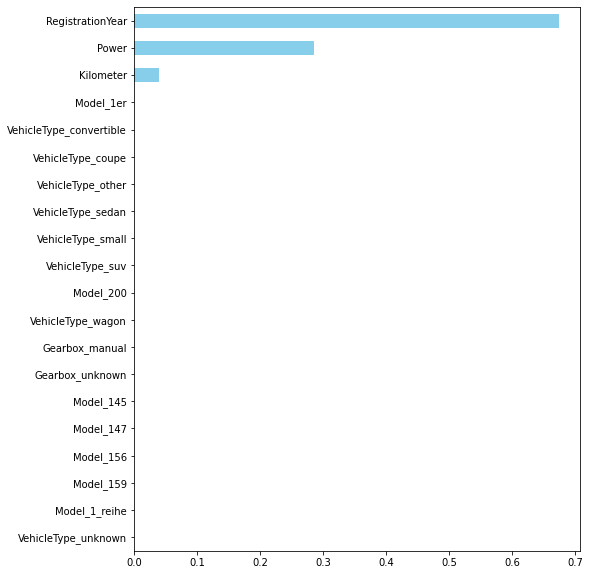

In [34]:
# посмотрим на feature importance модели
# после кодирования это конечно мало информативно
feat_imp = pd.Series(model_rf.feature_importances_, index=features_train.columns).nlargest(20).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(8,10), color='skyblue')

Случайный лес c гиперпараметрами по умолчанию у меня обучается очень долго (если не ограничивать глубину и кол-во оценщиков, то один фолд больше 10 мин.). 

Подбор гиперпараметров и кросс-валидацию проодить не стал, так как уже очевидно, что по условиям задачи данная модель не самая оптимальная для нас как по качеству, так и по скорости обучения.

Если подбирать гиперпараметры, то я бы это делал с помощью RandomizedSearchCV

### CatBoost

Для библиотек с бустингом буду использовать данные без кодирования категориальных признаков.  
Занаво разобью на выборки и обозначу их индексом `b`

Для CatBoost и LightGBM масштабировать данные не нужно.

In [35]:
features_b = df.drop('Price', axis = 1)
target_b = df['Price']

features_train_b, features_test_b, target_train_b, target_test_b = train_test_split(
    features_b, target_b, test_size=0.2, random_state=RANDOM_STATE) 


In [36]:
# категориальные признаки для CatBoost
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

# если включить PostalCode в категориальные, качество особе не меняется



In [37]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', iterations=1000, learning_rate=0.2, random_state=RANDOM_STATE)
model_cb.fit(features_train_b, target_train_b, cat_features=cat_features, verbose = 50)


0:	learn: 3963.2780060	total: 509ms	remaining: 8m 28s
50:	learn: 1759.3243546	total: 14.6s	remaining: 4m 30s
100:	learn: 1679.6433974	total: 28.7s	remaining: 4m 15s
150:	learn: 1646.6463706	total: 42.2s	remaining: 3m 57s
200:	learn: 1620.3114894	total: 56.7s	remaining: 3m 45s
250:	learn: 1598.0453462	total: 1m 10s	remaining: 3m 30s
300:	learn: 1584.2388010	total: 1m 24s	remaining: 3m 15s
350:	learn: 1570.9088641	total: 1m 38s	remaining: 3m 1s
400:	learn: 1559.7931343	total: 1m 52s	remaining: 2m 48s
450:	learn: 1549.8143260	total: 2m 7s	remaining: 2m 35s
500:	learn: 1541.3879345	total: 2m 22s	remaining: 2m 21s
550:	learn: 1532.4516263	total: 2m 36s	remaining: 2m 7s
600:	learn: 1525.9302603	total: 2m 51s	remaining: 1m 53s
650:	learn: 1519.1609118	total: 3m 6s	remaining: 1m 39s
700:	learn: 1511.9098825	total: 3m 21s	remaining: 1m 25s
750:	learn: 1505.0112884	total: 3m 36s	remaining: 1m 11s
800:	learn: 1498.6021363	total: 3m 51s	remaining: 57.5s
850:	learn: 1493.3659123	total: 4m 5s	remain

In [38]:
%%time

# проверим метрику RMSE с помощью кроссвалидации из библиоткеи CatBoost

params = {'iterations': 500,
          'loss_function': 'RMSE',
         'learning_rate': 0.2}

cv_data = cv(
    params=params,
    pool=Pool(features_train_b, label=target_train_b, cat_features=cat_features),
    fold_count=3, 
    shuffle=True, # Перемешаем наши данные
    plot=True, # визуализатор
    verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 1624.516434
bestIteration = 499

Training on fold [1/3]

bestTest = 1606.800311
bestIteration = 499

Training on fold [2/3]

bestTest = 1599.947898
bestIteration = 499

Wall time: 6min 12s


<AxesSubplot:>

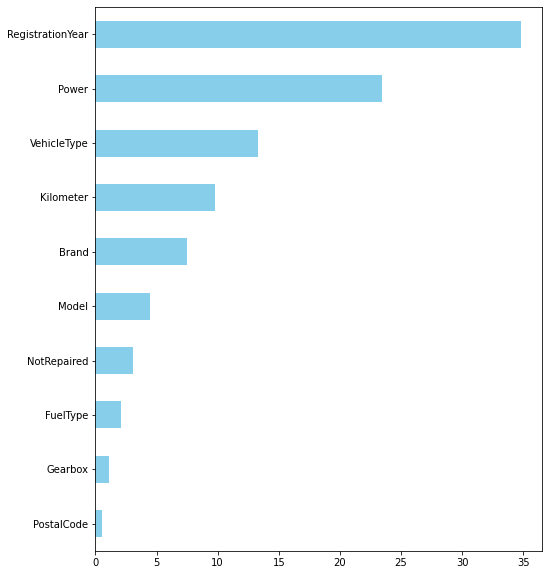

In [39]:
# посмотрим на feature importance модели
feat_imp = pd.Series(model_cb.feature_importances_, index=features_train_b.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(8,10), color='skyblue')

Любопытный feature importandce получился, если сравнивать CatBoost и LightGBM

В catboost cv красивое конечно, но результаты странные - на всех фолдах метрика хуже чем RMSE на тестовой, возможно я не правильно задал аргументы.

Проще для всех алгоритмов использовать кросс-валидацию sklearn
    

### LightGBM

In [40]:
categorical_feature = ['VehicleType',
                       'Gearbox',
                       'Model',
                       'FuelType',
                       'Brand',
                       'NotRepaired',
                      'PostalCode']

In [41]:
# LightGBM ругается на тип object, требуется приведение категориальных признаков к типу category
features_train_b_cat = features_train_b.copy()
features_test_b_cat = features_test_b.copy()
features_train_b_cat[categorical_feature] = features_train_b[categorical_feature].astype('category')
features_test_b_cat[categorical_feature] = features_test_b[categorical_feature].astype('category')

In [42]:
%%time
model_lgbmr = LGBMRegressor(n_estimators=1000, learning_rate=0.2, random_state=RANDOM_STATE)
model_lgbmr.fit(features_train_b_cat, target_train_b, categorical_feature=categorical_feature)

Wall time: 8.25 s


LGBMRegressor(learning_rate=0.2, n_estimators=1000, random_state=12345)

In [43]:
%%time
# проверим метрику RMSE с помощью кроссвалидации
cross_val_score(model_lgbmr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=3).mean()

Wall time: 30.2 s


-1567.7140615512271

#### OptunaSearch for LigthGBM
GridSearch по моему опыту оверкил, воспользовался новым для меня фреймворком optuna.

In [44]:
# зададим диапазоны параметров для OptunaSearchCV
params_search = {'learning_rate': optuna.distributions.UniformDistribution(0.05, 0.5),
                'n_estimators': optuna.distributions.IntUniformDistribution(100, 1400, 100),
                'subsample': optuna.distributions.UniformDistribution(0.8, 1)}
#                 'max_depth': optuna.distributions.IntUniformDistribution(0, 15, 1)}

In [45]:
model_os = LGBMRegressor()

opt_search = optuna.integration.OptunaSearchCV(
    model_os, params_search, cv=3, n_trials=15, scoring='neg_root_mean_squared_error', timeout=500)

In [46]:
%%time
opt_search.fit(features_train_b_cat, target_train_b)

[I 2022-09-13 12:24:05,144] A new study created in memory with name: no-name-717d546e-2ac4-4496-a7cb-60233d580e4e
[I 2022-09-13 12:24:16,440] Trial 0 finished with value: -1591.3385349367854 and parameters: {'learning_rate': 0.08091264272955132, 'n_estimators': 300, 'subsample': 0.8940817986828626}. Best is trial 0 with value: -1591.3385349367854.
[I 2022-09-13 12:24:49,938] Trial 1 finished with value: -1625.6869174879591 and parameters: {'learning_rate': 0.47216534095555274, 'n_estimators': 1300, 'subsample': 0.9476116195446397}. Best is trial 0 with value: -1591.3385349367854.
[I 2022-09-13 12:25:17,572] Trial 2 finished with value: -1554.877057133169 and parameters: {'learning_rate': 0.1341221940676605, 'n_estimators': 1000, 'subsample': 0.8848747562789224}. Best is trial 2 with value: -1554.877057133169.
[I 2022-09-13 12:25:39,292] Trial 3 finished with value: -1570.2301632247625 and parameters: {'learning_rate': 0.23828175183634903, 'n_estimators': 800, 'subsample': 0.91387855294

Wall time: 49min 8s


OptunaSearchCV(cv=3, estimator=LGBMRegressor(), n_trials=15,
               param_distributions={'learning_rate': UniformDistribution(high=0.5, low=0.05),
                                    'n_estimators': IntUniformDistribution(high=1400, low=100, step=100),
                                    'subsample': UniformDistribution(high=1.0, low=0.8)},
               scoring='neg_root_mean_squared_error', timeout=500)

In [47]:
opt_search.best_params_

{'learning_rate': 0.1341221940676605,
 'n_estimators': 1000,
 'subsample': 0.8848747562789224}

In [48]:
opt_search.best_score_

-1554.877057133169

<AxesSubplot:>

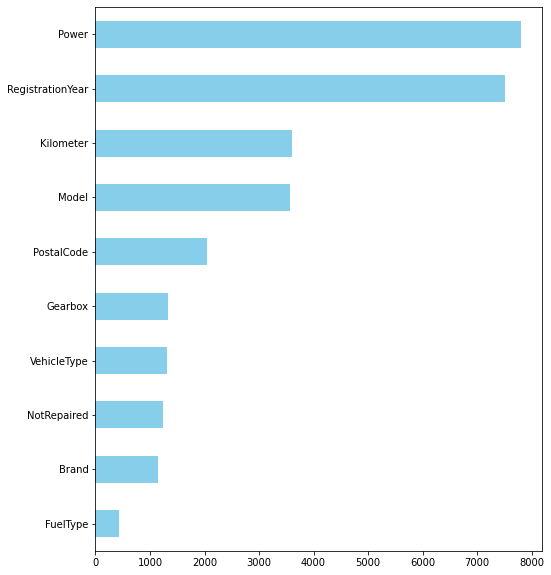

In [49]:
# посмотрим на feature importance модели
feat_imp = pd.Series(model_lgbmr.feature_importances_, index=features_train_b_cat.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh', figsize=(8,10), color='skyblue')

## Анализ моделей. Вывод

Критерии оценки моделей для нас:
* качество предсказания (не тестовой выборке);
* скорость предсказания;
* время обучения.

Базовые модели:
* Linear Regression -       RMSE 2606, fit 10.2s, predict 115ms;
* Random Forest Regressor - RMSE 2923, fit 1min 55s, predict 231ms. 

Базовые можели линейной регрессии и случайного леса показали довольно посредственные значения метрики RMSE 2772.36 и 2381.82, а в случае случайного леса еще и довольно длительное время обучения (возможная причина - не оптимальная предобработка данных).

Среди моделей с бустингом результаты по качеству скожи:
* CatBoost - RMSE 1580, fit 8min 56s, predict 580 ms; 
* LightGBM - RMSE 1532, fit 8.1s, predict 2.3s.

По времени обучения на наших данных LightGBM лидирует со значительным отрывом - около 15 с против 4-9 мин у CatBost.
Вместе с тем скорость предсказания у CatBoost слегка выше - 1 с против 2 с у LightGBM.

Итоговой выбор для презентации заказчику - модель LightGBM.

In [51]:
%%time
# Линейная регрессия на тестовой выборке
model_metrics(target_test, model_lr.predict(features_test))

RMSE: 2606.99
MSE:  6796406.21
R2:   0.6734
MAE:  1804.53
MAPE: 13.06
____________________
Wall time: 97.7 ms


In [52]:
%%time
# Случайный лес на тестовой выборке
model_metrics(target_test, model_rf.predict(features_test))

RMSE: 2923.66
MSE:  8547764.19
R2:   0.5892
MAE:  2021.64
MAPE: 12.25
____________________
Wall time: 245 ms


In [53]:
%%time
# CatBoost на тестовой выборке
model_metrics(target_test_b, model_cb.predict(features_test_b))

RMSE: 1580.47
MSE:  2497898.71
R2:   0.8800
MAE:  975.61
MAPE: 8.20
____________________
Wall time: 587 ms


In [54]:
%%time
# LightGBM на тестовой выборке (c гиперпараметрами подобранными OptunaSearch)
model_metrics(target_test_b, opt_search.best_estimator_.predict(features_test_b_cat))

RMSE: 1537.65
MSE:  2364353.45
R2:   0.8864
MAE:  942.59
MAPE: 8.24
____________________
Wall time: 1.9 s


**Upd**   
Что-то после манипуляций c Power и PostalCode у меня качество похуже стало (особенноу у базовых моделей), чем когда я просто все удалил. Но зато потренировался c интересной обработкой данных.
    